In [3]:
import numpy as np

# Load from NPZ format (recommended)
data = np.load("observations_sinusoidal.npz")
observations = data['observations']
timestamps = data['timestamps']
actions = data['actions']
states = data['states'] if 'states' in data else None

print(f"Observations shape: {observations.shape}")
print(f"Data keys: {list(data.keys())}")

Observations shape: (51, 1, 1)
Data keys: ['observations', 'timestamps', 'actions']


In [8]:
import numpy as np
Q= np.array([[1.5]], dtype=np.float64)*0
Q

array([[0.]])

In [10]:
observations[0:2]

array([[[0.12615797]],

       [[0.53803015]]])

In [11]:
observations_d = np.array([[[1.0]], [[2.0]], [[3.0]], [[4.0]]])

In [12]:
observations_d.shape

(4, 1, 1)

In [13]:

# Mask for every nth observation (e.g., every 5th observation)
sampling_mask = np.arange(0, len(observations_d), 2)
sampled_observations = observations_d[sampling_mask]

In [14]:
sampled_observations

array([[[1.]],

       [[3.]]])

# Masking with None Values

When you want to mask observations but keep the same array length, you can set masked positions to `None`. This preserves the temporal structure while indicating missing/masked data.

In [15]:
# Example: Create masked observations with None values
# Start with your loaded observations
print("Original observations shape:", observations.shape)
print("First 5 observations:")
print(observations[:5])

# Create a copy for masking (use object dtype to allow None)
masked_observations = np.empty(observations.shape[0], dtype=object)

# Copy the original observations
for i in range(len(observations)):
    masked_observations[i] = observations[i].copy()

print("\nMasked array created with shape:", masked_observations.shape)

Original observations shape: (51, 1, 1)
First 5 observations:
[[[0.12615797]]

 [[0.53803015]]

 [[0.15975223]]

 [[0.46371002]]

 [[0.42984675]]]

Masked array created with shape: (51,)


In [16]:
# Method 1: Random masking - set random observations to None
np.random.seed(42)
mask_probability = 0.3  # 30% of observations will be None

# Create random mask
random_mask = np.random.random(len(observations)) < mask_probability

# Apply mask - set selected positions to None
masked_obs_random = masked_observations.copy()
masked_obs_random[random_mask] = None

print(f"Randomly masked {np.sum(random_mask)} out of {len(observations)} observations")
print("First 10 elements (None = masked):")
print(masked_obs_random[:10])

Randomly masked 19 out of 51 observations
First 10 elements (None = masked):
[array([[0.12615797]]) array([[0.53803015]]) array([[0.15975223]])
 array([[0.46371002]]) None None None array([[0.22498989]])
 array([[0.42373395]]) array([[0.04455506]])]


In [ ]:
# Method 2: Systematic masking - every nth observation
mask_every_n = 3  # Mask every 3rd observation

masked_obs_systematic = masked_observations.copy()
# Set every nth observation to None
masked_obs_systematic[::mask_every_n] = None

print(f"Systematically masked every {mask_every_n}rd observation")
print("First 15 elements:")
print(masked_obs_systematic[:15])

In [ ]:
# Method 3: Time-based masking - mask specific time ranges
time_mask_start = 2.0
time_mask_end = 3.5

masked_obs_time = masked_observations.copy()
time_mask = (timestamps >= time_mask_start) & (timestamps <= time_mask_end)
masked_obs_time[time_mask] = None

print(f"Time-based masking: masked observations between {time_mask_start} and {time_mask_end}")
print(f"Masked {np.sum(time_mask)} observations")

# Method 4: Value-based masking - mask based on observation values
masked_obs_value = masked_observations.copy()
# Mask observations where first component is above a threshold
threshold = np.mean(observations[:, 0, 0])  # Use mean as threshold
value_mask = observations[:, 0, 0] > threshold
masked_obs_value[value_mask] = None

print(f"\nValue-based masking: masked {np.sum(value_mask)} observations above threshold {threshold:.3f}")

In [ ]:
# Utility functions for working with None-masked observations

def get_valid_observations(masked_obs_array):
    """Extract only non-None observations"""
    valid_indices = [i for i, obs in enumerate(masked_obs_array) if obs is not None]
    valid_obs = [masked_obs_array[i] for i in valid_indices]
    return np.array(valid_obs), valid_indices

def count_missing(masked_obs_array):
    """Count missing (None) observations"""
    return sum(1 for obs in masked_obs_array if obs is None)

def get_mask_pattern(masked_obs_array):
    """Get boolean mask where True = valid data, False = None"""
    return np.array([obs is not None for obs in masked_obs_array])

# Test the utility functions
valid_obs, valid_indices = get_valid_observations(masked_obs_random)
missing_count = count_missing(masked_obs_random)
mask_pattern = get_mask_pattern(masked_obs_random)

print(f"Valid observations: {len(valid_obs)}")
print(f"Missing observations: {missing_count}")
print(f"Total: {len(masked_obs_random)}")
print(f"Mask pattern (first 20): {mask_pattern[:20]}")

In [ ]:
def create_masked_observations(observations, timestamps, mask_type='random', **kwargs):
    """
    Create masked observations with None values
    
    Args:
        observations: Original observations array
        timestamps: Corresponding timestamps
        mask_type: 'random', 'systematic', 'time_range', 'value_based', 'custom'
        **kwargs: Additional parameters for specific mask types
    
    Returns:
        numpy array with None values at masked positions
    """
    # Create object array to hold None values
    masked_obs = np.empty(len(observations), dtype=object)
    
    # Copy original observations
    for i in range(len(observations)):
        masked_obs[i] = observations[i].copy()
    
    if mask_type == 'random':
        prob = kwargs.get('probability', 0.2)
        seed = kwargs.get('seed', 42)
        np.random.seed(seed)
        mask = np.random.random(len(observations)) < prob
        
    elif mask_type == 'systematic':
        step = kwargs.get('step', 3)
        mask = np.zeros(len(observations), dtype=bool)
        mask[::step] = True
        
    elif mask_type == 'time_range':
        t_start = kwargs.get('t_start', 1.0)
        t_end = kwargs.get('t_end', 3.0)
        mask = (timestamps >= t_start) & (timestamps <= t_end)
        
    elif mask_type == 'value_based':
        threshold = kwargs.get('threshold', np.mean(observations[:, 0, 0]))
        dim = kwargs.get('dimension', 0)
        mask = observations[:, dim, 0] > threshold
        
    elif mask_type == 'custom':
        mask = kwargs.get('mask', np.zeros(len(observations), dtype=bool))
        
    else:
        raise ValueError(f"Unknown mask_type: {mask_type}")
    
    # Apply mask
    masked_obs[mask] = None
    
    return masked_obs, mask

# Example usage of the comprehensive function
print("Creating different masked versions:")

# Random masking
masked_random, mask_random = create_masked_observations(
    observations, timestamps, 'random', probability=0.25, seed=123
)
print(f"Random mask: {np.sum(mask_random)} masked out of {len(observations)}")

# Time-based masking
masked_time, mask_time = create_masked_observations(
    observations, timestamps, 'time_range', t_start=1.5, t_end=2.5
)
print(f"Time mask: {np.sum(mask_time)} masked out of {len(observations)}")

# Custom pattern - mask every 4th observation starting from index 1
custom_mask = np.zeros(len(observations), dtype=bool)
custom_mask[1::4] = True
masked_custom, _ = create_masked_observations(
    observations, timestamps, 'custom', mask=custom_mask
)
print(f"Custom mask: {np.sum(custom_mask)} masked out of {len(observations)}")

In [ ]:
# Visualize the masking pattern
def print_mask_pattern(masked_obs, timestamps, max_display=30):
    """Print a visual representation of the mask pattern"""
    print("Mask pattern (✓ = valid data, ✗ = None):")
    pattern = ""
    times = ""
    
    display_length = min(len(masked_obs), max_display)
    
    for i in range(display_length):
        if masked_obs[i] is not None:
            pattern += "✓ "
            times += f"{timestamps[i]:.1f} "
        else:
            pattern += "✗ "
            times += "--- "
    
    if len(masked_obs) > max_display:
        pattern += "..."
        times += "..."
    
    print("Pattern:", pattern)
    print("Times:  ", times)
    print()

# Test the visualization
print("Random masking pattern:")
print_mask_pattern(masked_random, timestamps)

print("Time-based masking pattern:")
print_mask_pattern(masked_time, timestamps)

print("Custom masking pattern:")
print_mask_pattern(masked_custom, timestamps)

In [17]:
np.pow(np.array([[5]]), 2)

array([[25]])

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations


In [18]:
actions[3]

array([0.])

In [62]:
from models.linear_model import LinearModel_Estimator
from calibrator_module.BCUC_calibrator import BCUC_Calibrator
from models.model_utils import params

data = np.load("observations/first_person/observations_random_zeros_and_actions_for_Q0.0001_initialModel_1.5.npz")
masked_observations = mask_observations(data['observations'])
actions = data['actions']

patient_1_model = LinearModel_Estimator(**params) #Q_initial = 0.1
print(f"Initial Q matrix: {patient_1_model.Q}")
print(f"wanted Q matrix: 0")
calibrator = BCUC_Calibrator(patient_1_model)  # Note: Capital 'C' in Calibrator
patient_1_calibrater = calibrator.calibrate_model(masked_observations, actions)
boolFlag = patient_1_model is patient_1_calibrater

print(f"calibrated Q :{patient_1_calibrater.Q}")


Initial Q matrix: [[0.0001]]
wanted Q matrix: 0
e_t:0, mean_error = 0.0
mean_last_k: 0.0
Updated Q : [[9.99716588e-05]], q: 0.9985819342849972
e_t:1, mean_error = 0.5
mean_last_k: 0.5
Updated Q : [[0.00010033]], q: 1.017679435975943
e_t:1, mean_error = 0.6666666666666666
mean_last_k: 0.6666666666666666
Updated Q : [[0.00010131]], q: 1.0476776069869533
e_t:1, mean_error = 0.75
mean_last_k: 0.75
Updated Q : [[0.00010309]], q: 1.084331530817407
e_t:1, mean_error = 0.8
mean_last_k: 0.8
Updated Q : [[0.00010585]], q: 1.1259731846411176
e_t:1, mean_error = 0.8333333333333334
mean_last_k: 0.8333333333333334
Updated Q : [[0.0001098]], q: 1.1718330728442885
e_t:0, mean_error = 0.7142857142857143
mean_last_k: 0.7142857142857143
Updated Q : [[0.0001149]], q: 1.2100310964427636
e_t:1, mean_error = 0.75
mean_last_k: 0.75
Updated Q : [[0.00012143]], q: 1.2523651000958986
e_t:1, mean_error = 0.7777777777777778
mean_last_k: 0.7777777777777778
Updated Q : [[0.00012976]], q: 1.2985445160072957
e_t:1, me

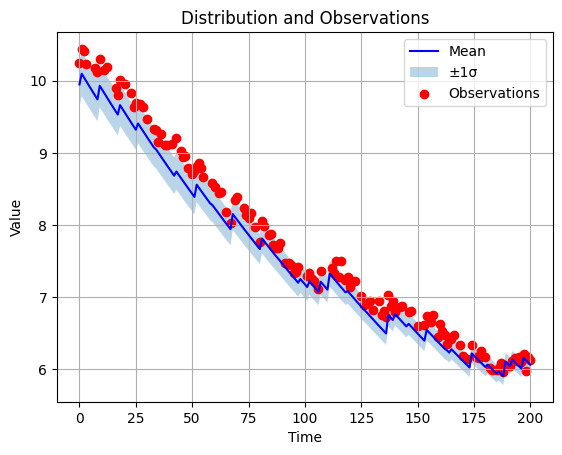

In [ ]:
mean = []
std = []
observations = masked_observations
patient_1_model.reset()
# mean.append(params['initial_mean'].flatten())
# std.append(np.sqrt(params['initial_cov']))
for obs, action in zip(observations, actions):
    meu, cov = patient_1_model.predict(action)
    mean.append(meu.item())
    std.append(np.sqrt(cov.item()))
    
ts = np.arange(len(mean)) 
mask = ~np.isnan(observations)
ts_valid = ts[mask.flatten()]
obs_valid = observations[mask.flatten()]
mean = np.array(mean)
std = np.array(std)
# Plot mean and confidence interval
plt.plot(ts, mean, label='Mean', color='blue')
plt.fill_between(ts, mean - std, mean + std, alpha=0.3, label='±1σ')

# Plot observations (only valid ones)
plt.scatter(ts_valid, obs_valid, color='red', label='Observations')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.title("Distribution and Observations")
plt.show()

In [ ]:
within_band = np.abs(obs_valid - mean[mask.flatten()]) <= std[mask.flatten()]
coverage = np.mean(within_band)  # should be ~0.68
coverage 

np.float64(0.09465020576131687)

In [50]:
obs_valid.shape

(135, 1)

In [32]:
ts.shape

(202,)

Text(0.5, 1.0, 'Error Over Time')

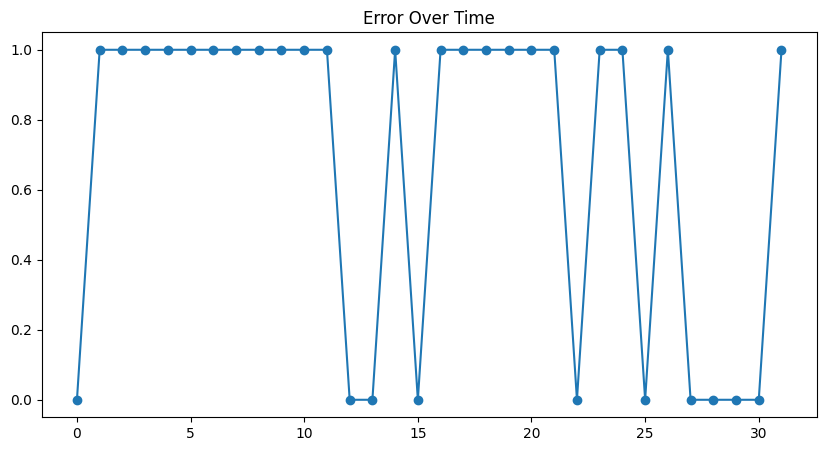

In [44]:
import matplotlib.pyplot as plt
# Plot the calibrated quantile over time
plt.figure(figsize=(10, 5))
plt.plot(calibrator.conformal_p_control.E, label='array of errors', marker='o')
plt.title('Error Over Time')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations


In [58]:
from models.linear_model import LinearModel_Estimator
from calibrator_module.BCUC_calibrator import BCUC_Calibrator
from models.model_utils import params

data = np.load("observations/first_person/observations_sinusoidal_for_Q0.5_initialModel_1.5.npz")
masked_observations = mask_observations(data['observations'])
actions = data['actions']
patient_1_model = LinearModel_Estimator(**params) #Q_initial = 1.5
print(f"Initial Q matrix: {patient_1_model.Q}")
print(f"wanted Q matrix: 0.5")
calibrator = BCUC_Calibrator(patient_1_model)  # Note: Capital 'C' in Calibrator
patient_1_calibrater = calibrator.calibrate_model(masked_observations, actions)
print(f"Calibrated Q :{patient_1_calibrater.Q}")


Initial Q matrix: [[1.5]]
wanted Q matrix: 0.5
e_t:0, mean = nan
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.0
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.0
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.0
Updated Q : [[1.5]], q: 1.0
e_t:1, mean = 0.0
Updated Q : [[1.5]], q: 1.0
e_t:1, mean = 0.2
Updated Q : [[1.5]], q: 1.0
e_t:1, mean = 0.3333333333333333
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.42857142857142855
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.375
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.3333333333333333
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.3
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.2727272727272727
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.25
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.23076923076923078
Updated Q : [[1.5]], q: 1.0
e_t:1, mean = 0.21428571428571427
Updated Q : [[1.5]], q: 1.0
e_t:1, mean = 0.26666666666666666
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.3125
Updated Q : [[1.5]], q: 1.0
e_t:0, mean = 0.29411764705882354
Updated Q : [[1.5]], q

/home/urig/liel/reliability_in_ML/B-CUQ/bcuq/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/urig/liel/reliability_in_ML/B-CUQ/bcuq/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Preventing __pycache__ Creation

Python creates `__pycache__` directories to store compiled bytecode (.pyc files) for faster module loading. Here are several ways to prevent this:

## Method 1: Environment Variable (Recommended for development)
Set `PYTHONDONTWRITEBYTECODE=1` in your environment.

## Method 2: Python Command Line Flag
Use `python -B` when running scripts.

## Method 3: Programmatically in Code
Set `sys.dont_write_bytecode = True` at the start of your code.

## Method 4: .gitignore (for version control)
Add `__pycache__/` and `*.pyc` to your .gitignore file to ignore these files in git.

Let's demonstrate these methods:

In [ ]:
# Method 3: Disable bytecode creation programmatically
import sys

# Check current setting
print(f"Current dont_write_bytecode setting: {sys.dont_write_bytecode}")

# Disable bytecode creation
sys.dont_write_bytecode = True
print(f"After setting: {sys.dont_write_bytecode}")

# This setting affects all subsequent imports in this session
# Note: This won't affect modules already imported, but will prevent
# new __pycache__ directories from being created for future imports

In [2]:
# Method 1: Check and set environment variable
import os

# Check if environment variable is set
current_setting = os.environ.get('PYTHONDONTWRITEBYTECODE', 'Not set')
print(f"PYTHONDONTWRITEBYTECODE environment variable: {current_setting}")

# Set it programmatically for this session
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
print("Environment variable set to '1' for this session")

# Note: For permanent effect, you can:
# 1. Add 'export PYTHONDONTWRITEBYTECODE=1' to your ~/.bashrc or ~/.bash_profile
# 2. Set it in VS Code settings or launch configuration
# 3. Set it in your virtual environment activation script

PYTHONDONTWRITEBYTECODE environment variable: Not set
Environment variable set to '1' for this session


In [8]:
# Clean up existing __pycache__ directories
import os
import shutil
from pathlib import Path

def find_and_remove_pycache(root_dir='.'):
    """Find and remove all __pycache__ directories"""
    root_path = Path(root_dir)
    pycache_dirs = list(root_path.rglob('__pycache__'))
    
    print(f"Found {len(pycache_dirs)} __pycache__ directories:")
    for pycache_dir in pycache_dirs:
        print(f"  {pycache_dir}")
        try:
            shutil.rmtree(pycache_dir)
            print(f"  ✓ Removed {pycache_dir}")
        except Exception as e:
            print(f"  ✗ Failed to remove {pycache_dir}: {e}")
    
    return len(pycache_dirs)

#Example: Clean current directory (uncomment to run)
removed_count = find_and_remove_pycache('.')
print(f"\nCleaned up {removed_count} __pycache__ directories")

print("Uncomment the lines above to actually remove __pycache__ directories")

Found 1 __pycache__ directories:
  bcuq/lib/python3.10/site-packages/zmq/utils/__pycache__
  ✓ Removed bcuq/lib/python3.10/site-packages/zmq/utils/__pycache__

Cleaned up 1 __pycache__ directories
Uncomment the lines above to actually remove __pycache__ directories


## Terminal Commands for __pycache__ Management

### Set environment variable permanently (add to ~/.bashrc):
```bash
echo 'export PYTHONDONTWRITEBYTECODE=1' >> ~/.bashrc
source ~/.bashrc
```

### Run Python with bytecode disabled:
```bash
python -B your_script.py
```

### Remove all __pycache__ directories recursively:
```bash
find . -type d -name "__pycache__" -exec rm -rf {} +
```

### Or using fd (if installed):
```bash
fd -t d "__pycache__" -x rm -rf
```

## VS Code Configuration

Add to your VS Code `settings.json`:
```json
{
    "python.terminal.launchArgs": ["-B"],
    "python.defaultInterpreterPath": "python -B"
}
```

## For Virtual Environments

Add to your virtual environment's activation script:
```bash
# In bcuq/bin/activate (or pyvenv.cfg)
export PYTHONDONTWRITEBYTECODE=1
```